In [1]:
seed = 13427256

# Q10

You want to create a “personal mixtape” for all 10k users we have explicit feedback for. This mixtape contains individualized recommendations as to which 10 songs (out of the 5k) a given user will enjoy most. How do these recommendations compare to the “greatest hits” from the previous question and how good is your recommender system in making recommendations?

In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed)

In [3]:
df_songs = pd.read_csv("spotify52kData.csv").iloc[:5000].sort_values(by='popularity', ascending=False)

In [4]:
indices_of_duplicates = df_songs[df_songs.duplicated(keep='first', subset=['artists', 'album_name', 'track_name', 'popularity'])].index.tolist()

In [5]:
df_songs = df_songs.drop(indices_of_duplicates).sort_values(by='songNumber')

In [6]:
df_stars = pd.read_parquet("starRatings.parquet").drop(columns=indices_of_duplicates)

In [7]:
df_songs.columns

Index(['songNumber', 'artists', 'album_name', 'track_name', 'popularity',
       'duration', 'explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre'],
      dtype='object')

In [8]:
df_songs['track_genre'].value_counts() # Seems to be distributed decently well. Will use the variable.

track_genre
acoustic       1000
afrobeat        999
ambient         999
alt-rock        763
alternative     637
Name: count, dtype: int64

In [9]:
df_songs['mode'].value_counts() # Seems to be distributed decently well. Will use the variable.

mode
1    2787
0    1611
Name: count, dtype: int64

In [10]:
df_songs['time_signature'].value_counts() # Most are in the 4 time signature, will not use the variable.

time_signature
4    3758
3     496
5      85
1      55
0       4
Name: count, dtype: int64

In [11]:
df_songs['explicit'].value_counts() # Will include the variable out of the theory that explicit listeners exist.

explicit
False    4140
True      258
Name: count, dtype: int64

## Approach
Create a model that predicts y := rating given to song for each predicted user.
For a user, run all 5000 models, get predicted ratings, and order for the top 10 songs.

## Data

We will do a 90/10 split. The 10 is a holdout set of users to evaluate our model on.

For the other 90, do a 80/20 split for CV/hyperparameter search.

## Feature Engineering

Since we are training a model per song, we only need per-user features. All of the features will be calculated for the user, without taking into account anything regarding the song being evaluated. Therefore, there will be 5000 feature engineering processes.

Features:
- User average rating (average rating the user gives across all songs).
- Weighted average var rating (average of var, weighted by the songs' given rating). Across the variables:
    - Popularity
    - Duration
    - Danceability
    - Energy
    - Loudness
    - Speechiness
    - Acousticness
    - Instrumentalness
    - Liveness
    - Valence
    - Tempo
- For each genre in track_genre:
    - genre_listen_perc (of the ratings, how many are of this genre).
- For each mode in mode:
    - mode_listen_perc (of the ratings, how many are of thise mode).
- Explicit hearing % (of the ratings, how many of the songs are explicit).

In [12]:
def generate_user_features(user_number):
    """
    Generates a user's features. Assumes that the effect of the song to predict for is negligible next to the other songs.
    """
    
    features = {}
    features['average_rating'] = df_stars.loc[user_number].mean()
    
    user_weights = df_stars.loc[user_number].fillna(0)

    # Generate weighted numeric variables
    for col in ['popularity', 'duration', 'danceability', 'energy',
              'loudness', 'speechiness', 'acousticness', 'instrumentalness',
              'liveness', 'valence', 'tempo']:
        features[f"{col}_weighted"] = np.average(df_songs[col], weights=user_weights)

    usr_song_idx = list(df_stars.columns[~df_stars.loc[user_number].isna()])
    df_usr_songs = df_songs.loc[usr_song_idx]
    
    features['explicit_percentage'] = df_usr_songs['explicit'].sum()/len(df_usr_songs)

    # Generate categorical variable percentage values
    for col in ['track_genre', 'mode']:
        for value in df_songs[col].unique():
            features[f'{col}_{value}'] = (df_usr_songs[col] == value).sum()/len(df_usr_songs)
            
    return features

In [13]:
user_features = [generate_user_features(i) for i in range(len(df_stars))]
df_features = pd.DataFrame(user_features)

In [14]:
df_features

,average_rating,popularity_weighted,duration_weighted,danceability_weighted,energy_weighted,loudness_weighted,speechiness_weighted,acousticness_weighted,instrumentalness_weighted,liveness_weighted,valence_weighted,tempo_weighted,explicit_percentage,track_genre_acoustic,track_genre_afrobeat,track_genre_alt-rock,track_genre_alternative,track_genre_ambient,mode_0,mode_1
0,1.543340,40.698630,231069.716438,0.562410,0.651177,-7.087533,0.058111,0.299797,0.135337,0.187617,0.488604,119.734399,0.057082,0.241015,0.224101,0.177590,0.152220,0.205074,0.395349,0.604651
1,2.371703,39.143579,237093.957533,0.535555,0.584662,-8.855089,0.060762,0.362109,0.152014,0.181933,0.456189,120.695888,0.057554,0.196643,0.232614,0.182254,0.143885,0.244604,0.369305,0.630695
2,2.676399,39.098182,230664.930000,0.541894,0.570573,-9.433720,0.064987,0.395050,0.194156,0.183515,0.481872,118.809024,0.063260,0.270073,0.272506,0.163017,0.121655,0.172749,0.328467,0.671533
3,2.073913,39.197065,228971.525157,0.540004,0.582653,-8.516239,0.062756,0.377842,0.173686,0.173280,0.452065,119.830908,0.050000,0.195652,0.239130,0.180435,0.147826,0.236957,0.345652,0.654348
4,2.786070,39.333036,224320.919643,0.523871,0.538657,-10.108101,0.056915,0.436177,0.238713,0.180454,0.444525,119.836990,0.047264,0.241294,0.221393,0.161692,0.129353,0.246269,0.355721,0.644279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.851415,44.387812,240645.842105,0.568042,0.737590,-5.979740,0.061754,0.211304,0.083541,0.187216,0.536768,120.497834,0.058962,0.228774,0.242925,0.169811,0.134434,0.224057,0.372642,0.627358
9996,1.909314,39.101412,232200.403081,0.563964,0.609919,-7.919357,0.064315,0.356301,0.140584,0.177809,0.460350,121.798874,0.046569,0.250000,0.227941,0.188725,0.127451,0.205882,0.394608,0.605392
9997,2.759009,37.777143,233432.452245,0.535404,0.579235,-8.848654,0.054640,0.380913,0.176346,0.183903,0.461624,120.585586,0.049550,0.247748,0.180180,0.209459,0.139640,0.222973,0.378378,0.621622
9998,1.751678,40.072797,235228.315453,0.561215,0.645046,-7.459789,0.061860,0.295369,0.122682,0.194801,0.492854,118.876019,0.078300,0.248322,0.221477,0.158837,0.181208,0.190157,0.380313,0.619687


Finally, to predict the rating, we don't care about predicting very low ratings. We decided to reduce to three classes:
- 0-3: not interested
- 4: mildly interested
- 5: interested

In [15]:
def bin_low_ratings(x):
    if x <= 3:
        return 3
    return x

df_stars_original = df_stars.copy()
df_stars = df_stars.applymap(bin_low_ratings)

/var/folders/jt/k9b7wwrn7fnc6l3g0xlf5xn80000gn/T/ipykernel_37165/3555198545.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_stars = df_stars.applymap(bin_low_ratings)


In [16]:
def generate_datasets(test_prop = 0.1, eval_prop = 0.2):
    #First reserve 10% of all users, in order to evaluate the model.
    all_user_ids = list(range(len(df_features)))
    
    #90/10 split
    len_test_users = int(np.ceil(len(df_features) * test_prop))
    test_users = np.random.choice(all_user_ids, size = len_test_users, replace = False)
    non_test_users = [u for u in all_user_ids if u not in test_users]

    #Generate the per-song datasets
    song_train_idx = dict()
    song_val_idx = dict()
    
    for s in df_songs.songNumber:
        #80/20 split over the users that rated the song, for users not in the test dataset.
        song_users  = (df_stars[~df_stars[s].isna()]).index
        non_test_song_users = list(set(song_users).intersection(set(non_test_users)))
    
        len_song_val_users = int(np.ceil(len(non_test_song_users) * eval_prop))
        song_val_users = np.random.choice(non_test_song_users, size = len_song_val_users, replace = False)
    
        song_train_users = [u for u in non_test_song_users if u not in song_val_users]
    
        song_train_idx[s] = song_train_users
        song_val_idx[s] = song_val_users

    return test_users, song_train_idx, song_val_idx

In [17]:
try:
    # Try to load the existing datasets
    test_users = joblib.load("test_users.pkl")
    song_train_idx = joblib.load("song_train_idx.pkl")
    song_val_idx = joblib.load("song_val_idx.pkl")
    print("Loaded existing datasets.")
except FileNotFoundError:
    # If the file doesn't exist, create and save the models
    print("Datasets not found. Generating...")

    test_users, song_train_idx, song_val_idx = generate_datasets()
    # Save the datasets
    joblib.dump(test_users, "test_users.pkl")
    joblib.dump(song_train_idx, "song_train_idx.pkl")
    joblib.dump(song_val_idx, "song_val_idx.pkl")
    print("Generated/saved datasets.")

Loaded existing datasets.


### Training loop

In [18]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score

sampler = optuna.samplers.TPESampler(seed=seed)  # Make the sampler behave in a deterministic way.

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [19]:
def get_pipeline(**kwargs):
    return Pipeline([
                ('scaler', StandardScaler()),
                ('model', LogisticRegression(multi_class='multinomial',
                                             random_state=seed,
                                             max_iter=10000,
                                             solver='saga',
                                             **kwargs))
            ])

def train_song_model(song_number):

    X_train = df_features.loc[song_train_idx[song_number]].values
    y_train = df_stars[song_number].loc[song_train_idx[song_number]].values

    X_val = df_features.loc[song_val_idx[song_number]].values
    y_val = df_stars[song_number].loc[song_val_idx[song_number]].values
    
    def objective(trial):
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        
        C = trial.suggest_float("C", 1e-4, 1e4, log=True)
        
        pipeline = get_pipeline(penalty=penalty, C=C)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        return accuracy_score(y_val, y_pred)

    # Create an Optuna study
    study = optuna.create_study(direction="maximize", sampler=sampler)
    
    # Optimize the model hyperparameters
    study.optimize(objective, n_trials=100)
    
    # Train the model with the best hyperparameters
    pipeline = get_pipeline(**study.best_params)
    pipeline.fit(X_train, y_train)

    return pipeline

In [20]:
songs = df_songs.songNumber.values

In [21]:
try:
    # Try to load the existing model dictionary
    song_models = joblib.load("song_models_2.pkl")
    print("Loaded existing model dictionary.")
except FileNotFoundError:
    # If the file doesn't exist, create and save the models
    print("Model dictionary not found. Training models...")

    song_models = {s:train_song_model(s) for s in tqdm(songs)}
    # Save the trained models
    joblib.dump(song_models, "song_models_2.pkl")
    print("Trained models and saved model dictionary.")

Loaded existing model dictionary.


# Model evaluation

In [22]:
def pred_user(usr_number):
    """ Gives the real ranking (by rating), and the full prediction by preference of a single user."""
    X = df_features.loc[[usr_number]]
    y = df_stars_original.loc[usr_number].fillna(0)
    y_pred = [(s, song_models[s].predict(X.values)[0]) for s in songs]
    pred_order = [x[0] for x in sorted(y_pred, key=lambda x: x[1], reverse=True)]
    real_order = list(y.sort_values(ascending=False).index)
    return real_order, pred_order

In [23]:
test_user_ratings = [pred_user(u) for u in tqdm(test_users)]

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:40<00:00,  4.54it/s]


How do these recommendations compare to the “greatest hits” from the previous question?

In [24]:
#From Q9, the average star rating based ranking
avg_star_rating_order = joblib.load('avg_star_rating_order.pkl')

In [25]:
top_10_general = avg_star_rating_order[:10]

In [26]:
#Will use Jaccard similarity to measure how similar the users' top 10 lists are when compared to the popularity-based model.

def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [27]:
# Using Jaccard similarity to check this
similarities = [jaccard(r[1][:10],top_10_general) for r in test_user_ratings]

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcor

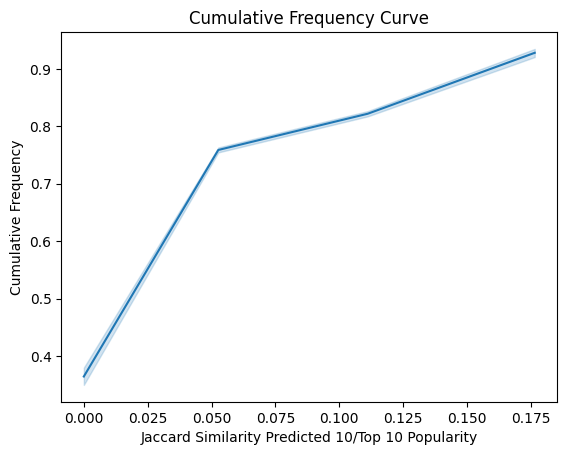

In [28]:
data_sorted = sorted(similarities)

# Calculating the cumulative frequency
cumulative_frequency = np.linspace(0., 1., len(similarities))

# Creating the plot
sns.lineplot(x=data_sorted, y=cumulative_frequency)
plt.xlabel('Jaccard Similarity Predicted 10/Top 10 Popularity')
plt.ylabel('Cumulative Frequency')
plt.title('Cumulative Frequency Curve')

# Show the plot
plt.show()

In [29]:
np.mean(similarities)

0.03613794289645683

How good is your recommender system in making recommendations?

In [30]:
#Using average precision @k to evaluate
def average_precision(ground_truth, prediction, k=100):
    hits = 0
    sum_precisions = 0
    ground_truth = ground_truth[:k]
    prediction = prediction[:k]
    for i, p in enumerate(prediction):
        if p in ground_truth:
            hits += 1
            precision_at_i = hits / (i + 1)
            sum_precisions += precision_at_i

    return sum_precisions / len(ground_truth)

## K = 10

In [31]:
at_k = 10

In [32]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @10 (ML Model)')

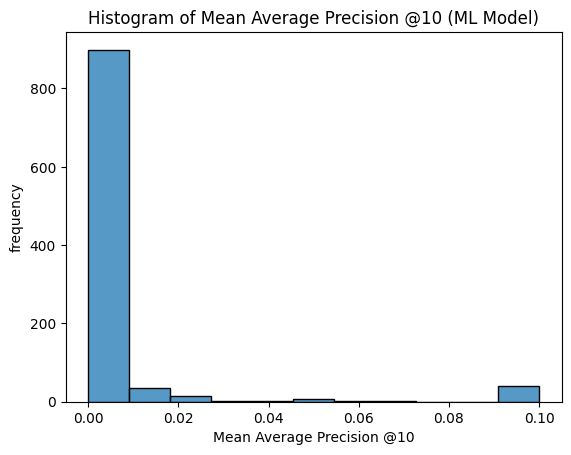

In [33]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [34]:
np.mean(pred_average_precisions)

0.0052862698412698425

In [35]:
np.median(pred_average_precisions)

0.0

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @10 (Popularity Model)')

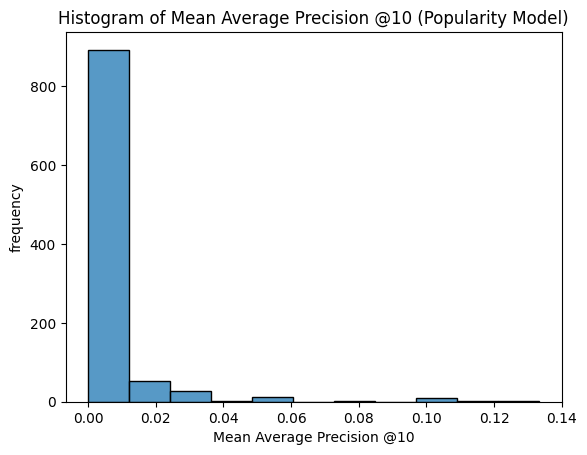

In [36]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [37]:
np.mean(pop_average_precisions)

0.0037954761904761903

In [38]:
np.median(pop_average_precisions)

0.0

## K = 20

In [39]:
at_k = 20

In [40]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @20 (ML Model)')

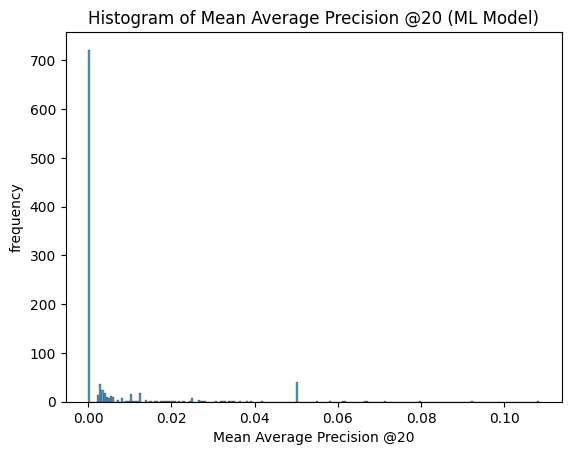

In [41]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [42]:
np.mean(pred_average_precisions)

0.004965604373696479

In [43]:
np.median(pred_average_precisions)

0.0

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @20 (Popularity Model)')

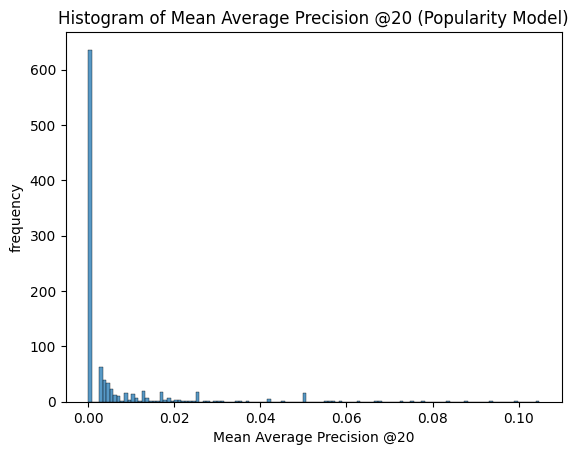

In [44]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [45]:
np.mean(pop_average_precisions)

0.0052765055955826074

In [46]:
np.median(pop_average_precisions)

0.0

## K = 50

In [47]:
at_k = 50

In [48]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @50 (ML Model)')

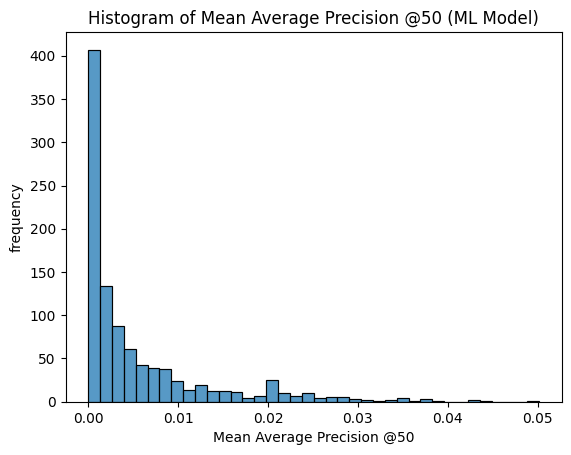

In [49]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [50]:
np.mean(pred_average_precisions)

0.005447616071684755

In [51]:
np.median(pred_average_precisions)

0.002073593073593074

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @50 (Popularity Model)')

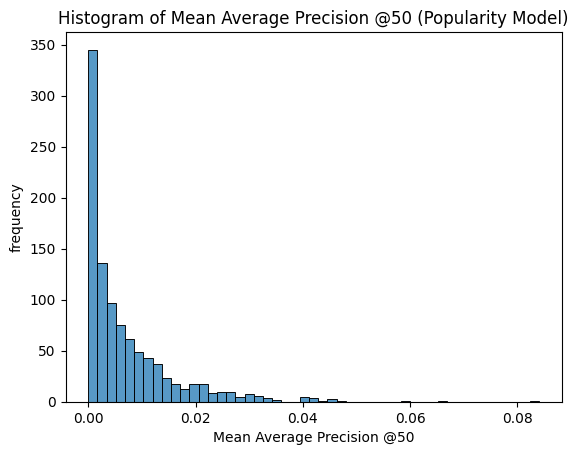

In [52]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [53]:
np.mean(pop_average_precisions)

0.007115536697202991

In [54]:
np.median(pop_average_precisions)

0.0037258129467431793

## K = 100

In [55]:
at_k = 100

In [56]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @100 (ML Model)')

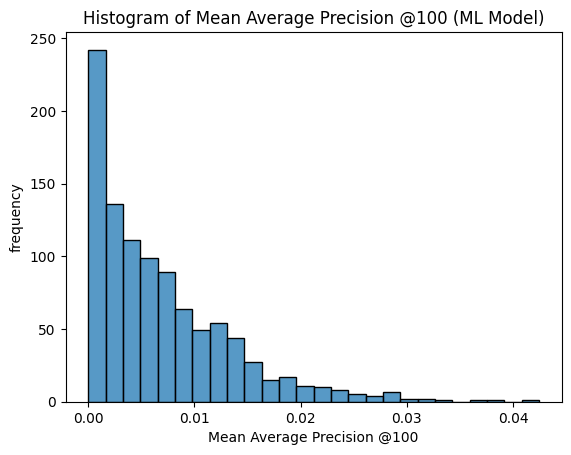

In [57]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [58]:
np.mean(pred_average_precisions)

0.006825899624840617

In [59]:
np.median(pred_average_precisions)

0.00507253730950229

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @100 (Popularity Model)')

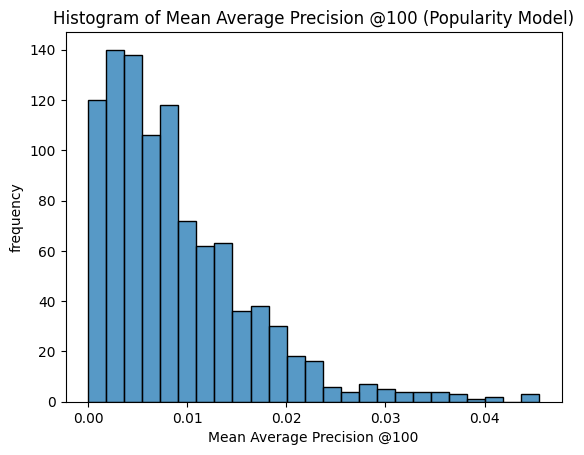

In [60]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [61]:
np.mean(pop_average_precisions)

0.008968535785549825

In [62]:
np.median(pop_average_precisions)

0.00720426413100271

## K = 250

In [63]:
at_k = 250

In [64]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @250 (ML Model)')

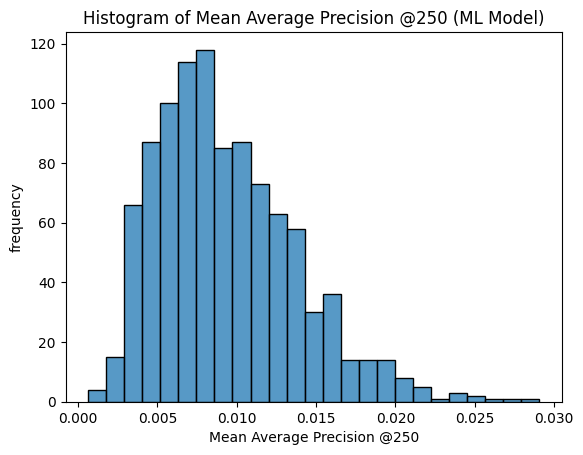

In [65]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [66]:
np.mean(pred_average_precisions)

0.009357273577807312

In [67]:
np.median(pred_average_precisions)

0.00854660849586112

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @250 (Popularity Model)')

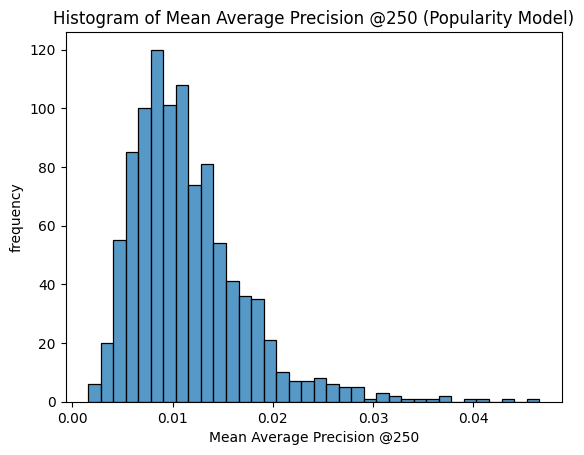

In [68]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [69]:
np.mean(pop_average_precisions)

0.011553550929631826

In [70]:
np.median(pop_average_precisions)

0.010436731914220818

## K = 500

In [71]:
at_k = 500

In [72]:
pred_average_precisions = []
pop_average_precisions = []

for real, pred in test_user_ratings:
    pred_average_precisions.append(average_precision(real, pred, k=at_k))
    pop_average_precisions.append(average_precision(real, avg_star_rating_order, k=at_k))


### Our model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @500 (ML Model)')

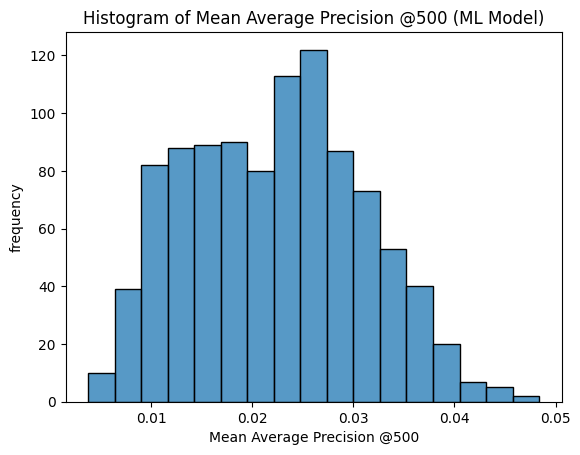

In [73]:
sns.histplot(pred_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (ML Model)')

In [74]:
np.mean(pred_average_precisions)

0.022318593520008284

In [75]:
np.median(pred_average_precisions)

0.022693412306832375

### Popularity-based model

/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/python_3_11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Mean Average Precision @500 (Popularity Model)')

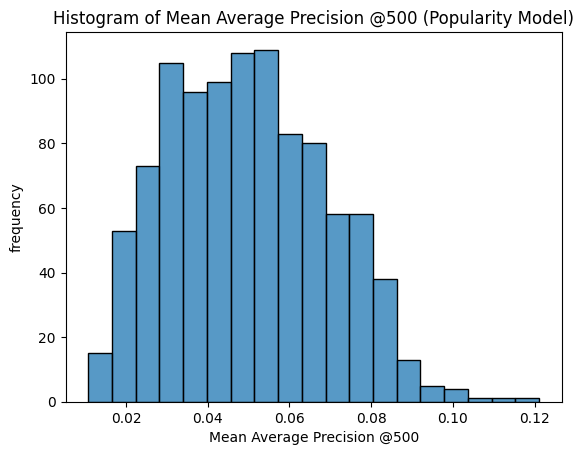

In [76]:
sns.histplot(pop_average_precisions)
plt.xlabel(f'Mean Average Precision @{at_k}')
plt.ylabel('frequency')
plt.title(f'Histogram of Mean Average Precision @{at_k} (Popularity Model)')

In [77]:
np.mean(pop_average_precisions)

0.049756943448022166

In [78]:
np.median(pop_average_precisions)

0.04871279808645418